In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Dane *Airline Passengers*


In [4]:
df_series = pd.read_csv('./AirPassengers.csv').set_index('Month')
df_series.index = pd.DatetimeIndex(df_series.index)
df_series.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Wydzielenie z danych części treningowej i testowej
Chcemy predykować szereg czasowy, a ponieważ dysponujemy dość długą historią lotów, weźmiemy 2 ostatnie lata (24 miesiące) jako zbiór testowy, a pozostały okres posłuży jako zbiór treningowy.

In [5]:
N_to_predict = 24
df_series_train = df_series.iloc[:-N_to_predict]
df_series_test = df_series.iloc[-N_to_predict:]

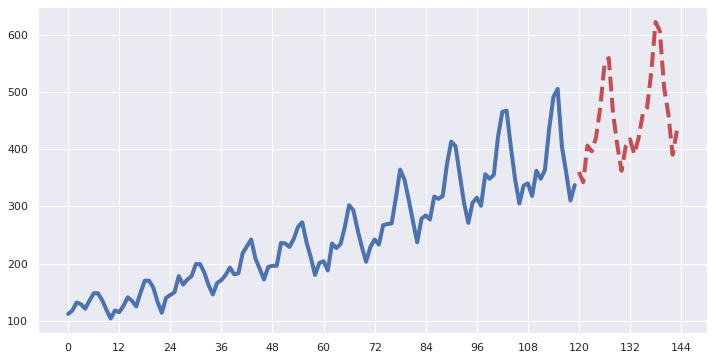

In [6]:
def simple_plot(values, xticks=12, predict=False):
    plt.figure(figsize=(12, 6))
    x = list(range(values.shape[0]))
    if predict:
        plt.plot(x[:-N_to_predict], values[:-N_to_predict], lw=4)
        plt.plot(x[-N_to_predict:], values[-N_to_predict:], lw=4, ls='--', c='r')
    else:
        plt.plot(x, values, lw=4)
    if xticks > 0:
        plt.xticks(range(0,values.shape[0]+1, xticks))
    plt.show()

series = df_series['#Passengers'].values
series_train = df_series_train['#Passengers'].values
series_test = df_series_test['#Passengers'].values

simple_plot(series, predict=True)

Jest to na pewno szereg czasowy :) 
Dane są podane co miesiąc, więc sezonowość (którą swoją drogą wyraźnie widać) przewidujemy na **okres 12 jednostek**. 
Nie widać żadnych outlierów, więc nie musimy nic usuwać i możemy przystąpić do rozbicia szeregu na części składowe:
- trend **T**
- sezonowość **S**
- komponent losowy (rezydualny) **R**


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

Który model wybrać - addytywny czy multiplikatywny?  

*Additive models are good for series with possible values that exibit an constant magnitude of fluctuations.
Multiplicative models are good for series with possible values that exibit an increasing magnitude of fluctuations.*  
(SAS for Forecasting Time Series, Third Edition)  
 
Z tego względu wybieramy model **multiplikatywny** i sprawdzamy jak wygląda dekompozycja szeregu treningowego.

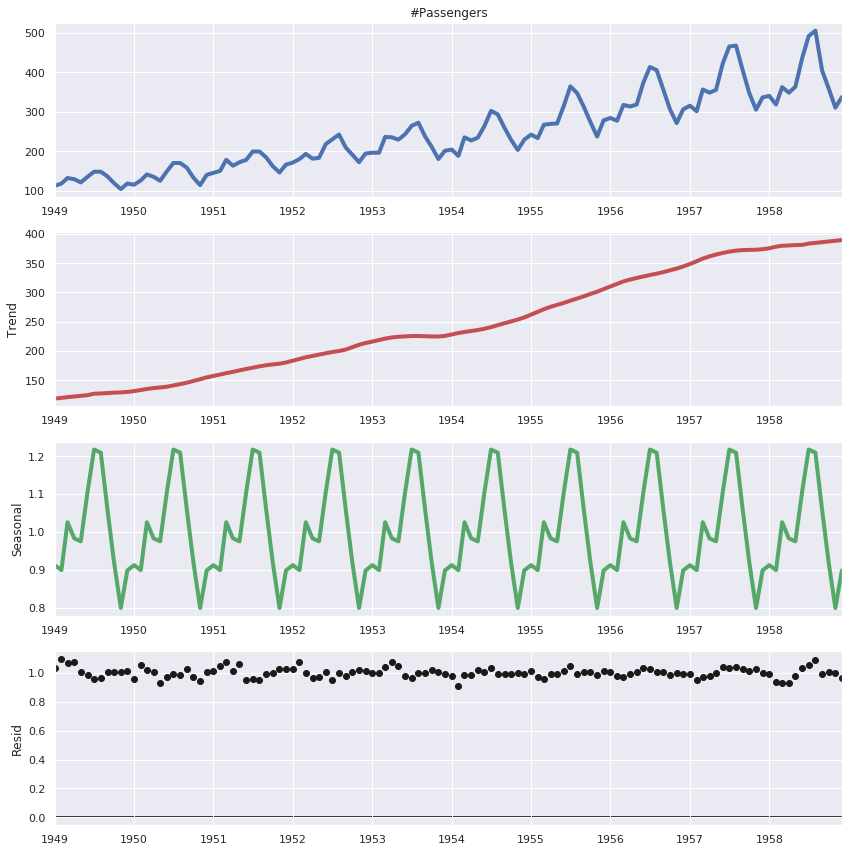

In [8]:
multiplicative_model = seasonal_decompose(df_series_train['#Passengers'], model='multiplicative', extrapolate_trend='freq')

def plot_sesonal_decompose(model):
    plt.rcParams["figure.figsize"] = (12, 12)
    colors = ['b', 'r', 'g', 'k']
    fig = model.plot()
    axes = fig.axes
    for i, ax in enumerate(axes):
        l = ax.get_lines()[0]
        l.set_color(colors[i])
        l.set_linewidth(4)
    plt.show()

plot_sesonal_decompose(multiplicative_model)

## Stacjonarność szeregu

Aby skutecznie predykować serie czasowe musimy doprowadzić szereg do stacjonarności.
Aby szereg czasowy był stacjonarny, muszą być spełnione wszystkie trzy warunki:
- stała wartość oczekiwana
- stałe odchylenie standardowe
- brak sezonowości

Nasz szereg czasowy ewidentnie jest sezonowy oraz nie ma stałej wartości oczekiwanej (występuje trend).
Musimy zatem pozbyć się sezonowości i trendu (będziemy to robić w tej kolejności).

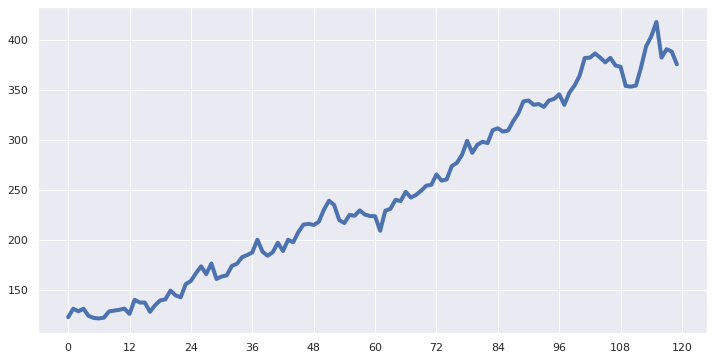

In [9]:
plt.rcParams["figure.figsize"] = (12, 6)

series_deseasonalized = series_train / multiplicative_model.seasonal
simple_plot(series_deseasonalized)

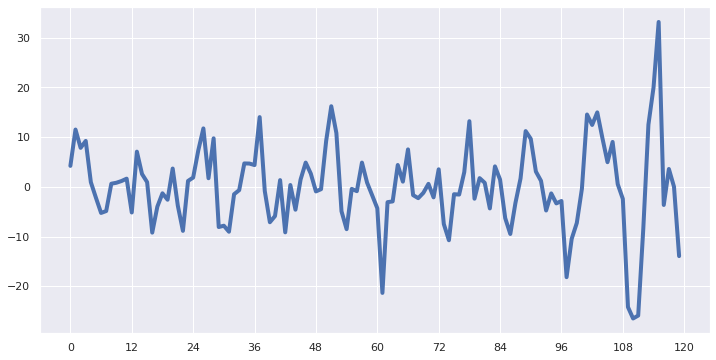

In [10]:
series_detrended = series_deseasonalized - multiplicative_model.trend
simple_plot(series_detrended)

### Sprawdzenie stacjonarności szeregu

Teraz możemy zastosować jakąś technikę sprawdzenia czy nasz szereg czasowy jest stacjonarny czy też jeszcze nie.  

Wykorzystamy **Test Dickeya-Fullera**, który zakłada niestacjonarność modelu. 
Jeśli hipoteza zerowa zostanie odrzucona (otrzymamy *p-value* < 0.05) to nasz szereg jest stacjonarny :)

In [11]:
from statsmodels.tsa.stattools import adfuller

In [16]:
df_test_decomposed = adfuller(series_detrended)
print(f'Szereg po odjęciu sezonowości i trendu:\n'
      f'p-value = {round(df_test_decomposed[1], 10)}')

Szereg po odjęciu sezonowości i trendu:
p-value = 0.0


Udało się - nasz szereg jest teraz stacjonarny (bo p-value = 0.0 < 0.05) i możemy analizować go dalej :)
Dla potwierdzenia, sprawdźmy jeszcze stacjonarność oryginalnego szeregu czasowego *Airline Passengers*

In [15]:
df_test_decomposed = adfuller(series_train)
print(f'Szereg oryginalny:\n'
      f'p-value = {round(df_test_decomposed[1], 4)}')

Szereg oryginalny:
p-value = 0.8268


Dla oryginalnego szeregu czasowego hipoteza zerowa nie została odrzucona (p-value = 0.83 > 0.05),
więc szereg jest niestacjonarny.  

## Model ARIMA
Model ARIMA zawiera w sobie infomację zarówno o zależnościach pomiędzy kolejnymi wartościami szeregu (model AR), 
jak i zależnościach pomiędzy czynnikami losowymi (model MA). Wydaje się uwzględniać najwięcej czynników, 
dlatego wykorzystamy właśnie ten model.  
 
Jeśli predykcja będzie wydawać się nie najlepsza, możemy spróbować uprościć model
np. do modelu AR (im prostszy, tym lepszy, o ile działa tak samo dobrze :)).  

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

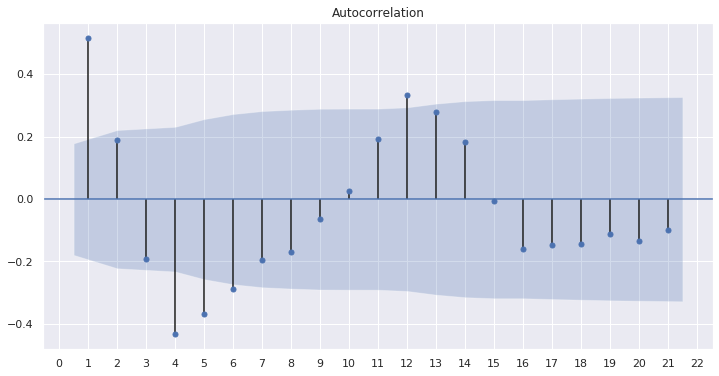

In [18]:
fig = plot_acf(series_detrended, zero=False)
fig.axes[0].set_xticks(range(23))
plt.show()

Narysowaliśmy autokorelogram - ACF.  

Widzimy piki (najbardziej odstające wartości) dla lagów wynoszących 1, 4, 5 i 12.
To oznacza, że nasz parametr q w modelu ARIMA(p, q) powinien przyjąć jedną z tych wartości.

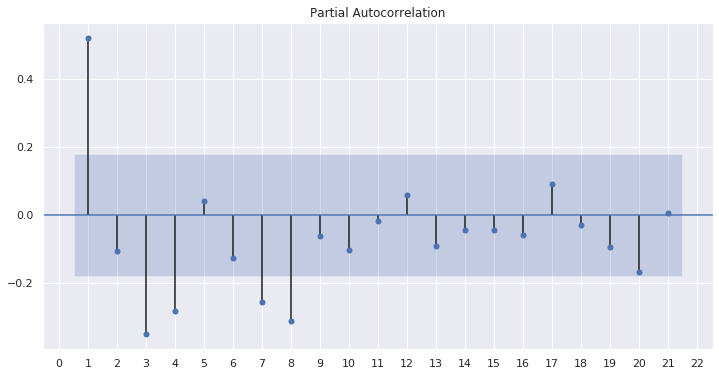

In [126]:
fig = plot_pacf(series_detrended, zero=False)
fig.axes[0].set_xticks(range(23))
plt.show()

Dla PACF (Partial ACF) widzimy najbardziej wyraźne piki dla 1 oraz 3 (ew. 8).
To znaczy, że parametr p w ARIMA(p, q) powinien wynosić 1 lub 3.


In [19]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [20]:
def get_forecast(series_detrended, series_detrended_test, arima_order=(1, 1, 1), N_to_predict=24):
    x_train, x_test = series_detrended, series_detrended_test

    model = ARIMA(x_train, order=arima_order)  # order = (p, differences, q)
    model_fitted = model.fit(disp=False)
    
    fc, _, _ = model_fitted.forecast(N_to_predict, alpha=0.05)  # 0.05 means we have 95% confidence
    forecast = pd.Series(fc, index=x_test.index)
    return x_train, x_test, forecast

Musimy jeszcze sprawić, aby testowa część zbioru (nasze 24 miesiące obserwacji) została sprowadzona do postaci stacjonarnej - robimy to w sposób analogiczny do zbioru treningowego.

In [21]:
multiplicative_model_test = seasonal_decompose(df_series_test['#Passengers'], model='multiplicative', extrapolate_trend='freq')
series_deseasonalized_test = series_test / multiplicative_model_test.seasonal
series_detrended_test = series_deseasonalized_test - multiplicative_model_test.trend

Chcemy uzyskać predykcję dla ostatniego roku, czyli ostatnich 24 miesiący (2 lat), stąd ```N_to_predict = 24```.  
Początkowo weźmy parametry do ARIMA równe ```p = 1, q = 1```.

In [22]:
x_train, x_test, forecast = get_forecast(series_detrended, series_detrended_test, arima_order=(1, 0, 1))

In [23]:
def detrended_to_original(values, model_trend, model_seasonal):
    return (values + model_trend) * model_seasonal

def plot_forecast(x_train, x_test, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(detrended_to_original(x_train, multiplicative_model.trend, multiplicative_model.seasonal), lw=4, label='training data')
    plt.plot(detrended_to_original(x_test, multiplicative_model_test.trend, multiplicative_model_test.seasonal), lw=4, label='real data')
    plt.plot(detrended_to_original(forecast, multiplicative_model_test.trend, multiplicative_model_test.seasonal), lw=4, label='forecast')
    plt.title(f'Forecast - Mean Squared Error (MSE) = {round(mean_squared_error(x_test, forecast), 1)}\n', fontsize=16)
    plt.legend()
    plt.show()

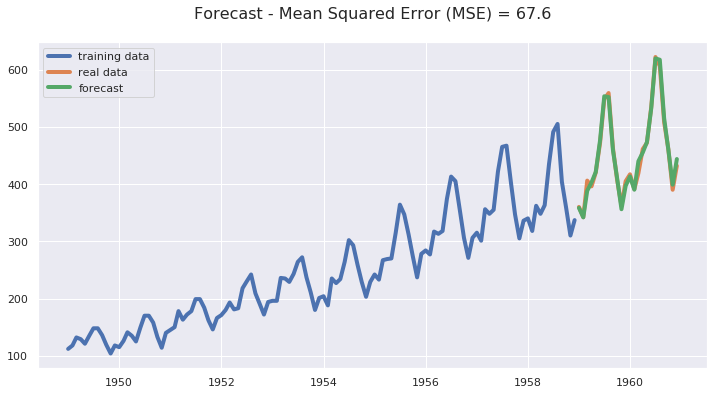

In [24]:
plot_forecast(x_train, x_test, forecast)

Wygląda bardzo w porządku :) Natomiast ciężko stwierdzić czy MSE równy około 70 to dużo czy mało. Możemy zatem sprawdzić modele ARIMA dla innych parametrów i porównać te wartości. Możemy wziąć wybrane największe piki dla ACF i PACF, które wcześniej wypisaliśmy.

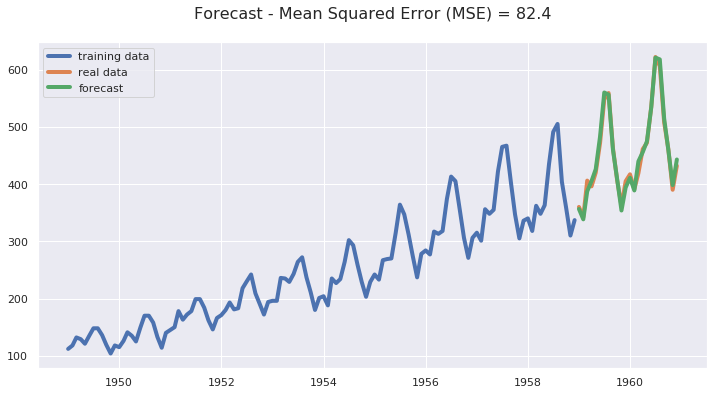

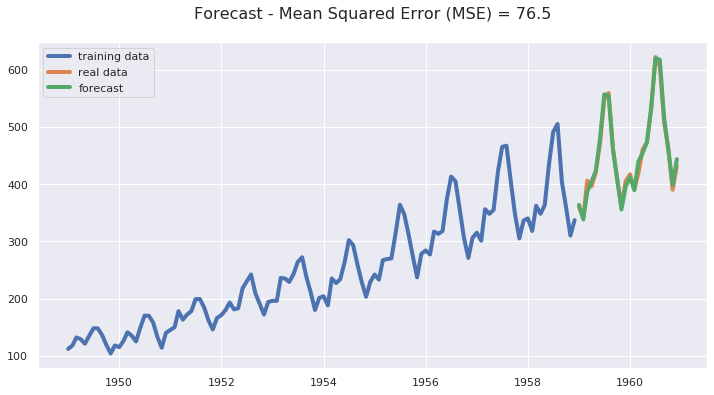

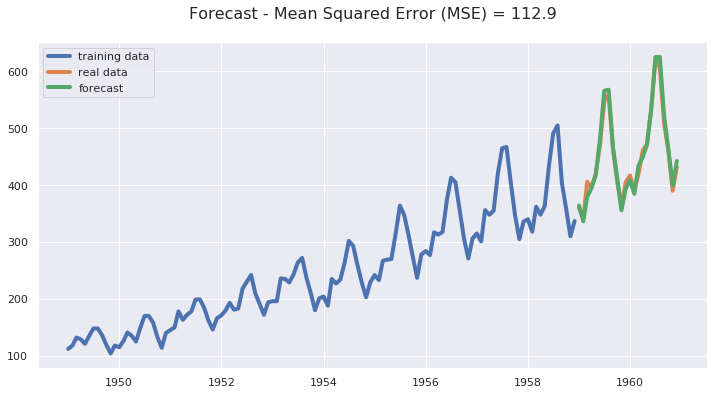

In [26]:
x_train, x_test, forecast = get_forecast(series_detrended, series_detrended_test, arima_order=(3, 0, 1))
plot_forecast(x_train, x_test, forecast)

x_train, x_test, forecast = get_forecast(series_detrended, series_detrended_test, arima_order=(3, 0, 5))
plot_forecast(x_train, x_test, forecast)

x_train, x_test, forecast = get_forecast(series_detrended, series_detrended_test, arima_order=(8, 0, 1))
plot_forecast(x_train, x_test, forecast)

Jednak dla początkowych ```p = 1``` i ```q = 1``` uzyskaliśmy najmniejszy MSE :) Natomiast "naocznie" wszystkie kombinacje wyglądają równie dobrze :) Choć nie warto oceniać wyników na oko, gdyż ostatnia predykcja wygląda równie dobrze, jak poprzednie, a jednak MSE jest prawie 2x większe, niż dla najlepszej kombinacji parametrów.

## Wnioski
- ważna jest zamiana szeregu czasowego na stacjonarny
    - warto do sprawdzenia stacjonarności szeregu wykorzystać jakiś test, a nie oceniać szeregu "na oko", bo może to być mylące
- warto poeksperymentować z parametrami modelu ARIMA (ustalonymi na podstawie ACF i PACF), żeby znaleźć optymalne
- model ARIMA całkiem dobrze predykuje szereg czasowy :)